In [1]:
get_ipython().run_cell_magic('capture', '', '!pip install db-dtypes\n!pip install keras\n!pip install tensorflow\n')

In [2]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [3]:
get_ipython().run_cell_magic('capture', '', 'import pandas as pd\nimport numpy as np\nimport os\nfrom google.cloud import bigquery\nfrom google.oauth2 import service_account\nfrom google.cloud.bigquery import magics\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.svm import SVR\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.linear_model import LassoCV\nfrom sklearn.model_selection import RepeatedKFold\nfrom sklearn.linear_model import BayesianRidge\nfrom sklearn.linear_model import ElasticNetCV\nfrom keras.models import Sequential\nfrom keras.layers import Bidirectional, LSTM, Dropout, Dense\n')

ModuleNotFoundError: No module named 'keras'

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query_main = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [6]:
query_job = bigquery_client.query(query_main)
unemployment_data = query_job.to_dataframe()

In [7]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [8]:
query_job = bigquery_client.query(query)
wage_data = query_job.to_dataframe()

In [9]:
query_pred = """
SELECT * 
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [10]:
query_job = bigquery_client.query(query_pred)
prediction_list = query_job.to_dataframe()

In [11]:
print(unemployment_data.info())
print(wage_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16833 entries, 0 to 16832
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uu_id                   16833 non-null  object
 1   timeperiod              16833 non-null  Int64 
 2   week_number             16833 non-null  Int64 
 3   countyfips              16833 non-null  Int64 
 4   tract                   16833 non-null  Int64 
 5   tract_name              16833 non-null  object
 6   total_claims            16833 non-null  Int64 
 7   edu_8th_or_less         13748 non-null  Int64 
 8   edu_grades_9_11         5942 non-null   Int64 
 9   edu_hs_grad_equiv       6036 non-null   Int64 
 10  edu_post_hs             3246 non-null   Int64 
 11  edu_unknown             12031 non-null  Int64 
 12  top_category_employer1  16833 non-null  object
 13  top_category_employer2  16833 non-null  object
 14  top_category_employer3  16833 non-null  object
 15  ge

In [12]:
# check shape of both frames to see if they are joinable
print('Unemployment df size:', unemployment_data.shape)
print('Wage df size:', wage_data.shape)

Unemployment df size: (16833, 25)
Wage df size: (525, 5)


In [13]:
unemployment_data.isnull().sum() / len(unemployment_data) * 100

uu_id                      0.000000
timeperiod                 0.000000
week_number                0.000000
countyfips                 0.000000
tract                      0.000000
tract_name                 0.000000
total_claims               0.000000
edu_8th_or_less           18.327096
edu_grades_9_11           64.700291
edu_hs_grad_equiv         64.141864
edu_post_hs               80.716450
edu_unknown               28.527298
top_category_employer1     0.000000
top_category_employer2     0.000000
top_category_employer3     0.000000
gender_female             77.217371
gender_male               76.647062
gender_na                  5.732787
race_amerindian            9.196222
race_asian                11.251708
race_black                57.678370
race_noanswer             40.064160
race_hawaiiannative        2.417870
race_other                52.028753
race_white                62.026971
dtype: float64

In [14]:
wage_data.isnull().sum() / len(wage_data) * 100

uu_id           0.0
countyfips      0.0
tract           0.0
tract_name      0.0
average_wage    0.0
dtype: float64

In [15]:
# replace values with 0
clean_unemploymentDf = unemployment_data.copy()
clean_unemploymentDf.fillna(0, inplace=True)
clean_unemploymentDf

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,...,0,0,0,0,0,11,0,0,0,0
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,0,108,...,76,35,0,0,0,0,0,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,0,0,...,0,0,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,0,0,...,0,0,0,0,0,10,0,0,0,0
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,0,69,...,90,65,0,0,0,135,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,f35320206f3dd1ffc411e4ac127caf92,20220618,25,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",21,0,0,0,...,0,0,0,0,0,0,0,0,0,14
16829,f35320206f3dd1ffc411e4ac127caf92,20220827,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,0,13,...,0,0,0,0,0,0,0,0,0,0
16830,f35320206f3dd1ffc411e4ac127caf92,20220827,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,0,13,...,0,0,0,0,0,0,0,0,0,0
16831,bbcb018f0e5e49e13636f6e78ce9f60f,20220326,13,18163,10203,"Census Tract 102.03, Vanderburgh County, Indiana",53,0,0,48,...,0,0,0,0,0,0,0,0,0,0


In [16]:
clean_unemploymentDf.isnull().sum() #check

uu_id                     0
timeperiod                0
week_number               0
countyfips                0
tract                     0
tract_name                0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
dtype: int64

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_14196/3330649336.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = clean_unemploymentDf.corr()


<AxesSubplot: >

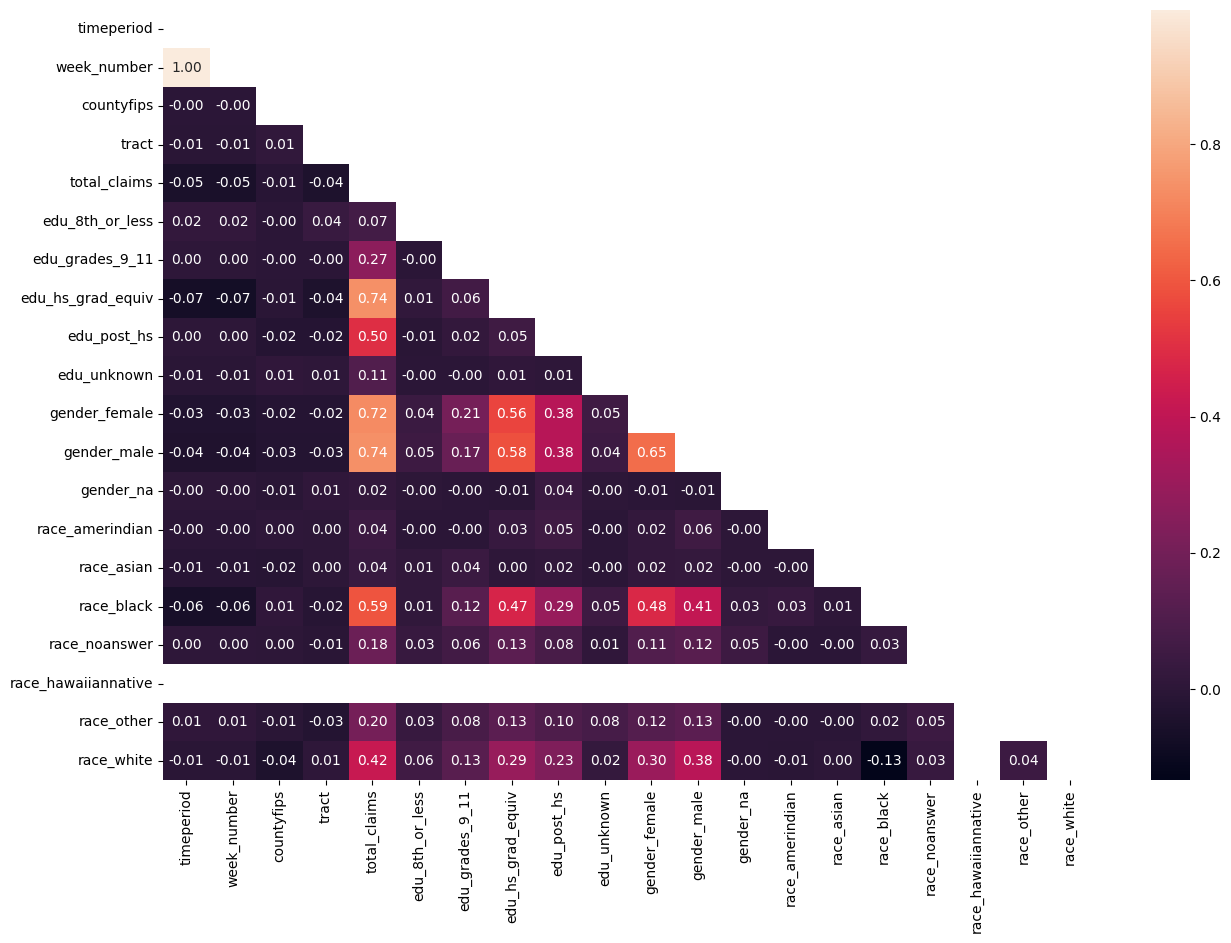

In [17]:
# check correlation
correlation = clean_unemploymentDf.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f')

In [18]:
# check wage information
wage_data[wage_data['average_wage'].isnull()] # there's 3 nulls here - might as well drop them and use this tract to attempt to join the datasets together; or impute with mean

,uu_id,countyfips,tract,tract_name,average_wage


In [19]:
#wage_data.dropna(axis=0, inplace=True)
wage_data['average_wage'].fillna(wage_data['average_wage'].mean(), inplace=True)
wage_data.isnull().sum()

uu_id           0
countyfips      0
tract           0
tract_name      0
average_wage    0
dtype: int64

In [20]:
wage_dupl = wage_data[wage_data.duplicated()]
print('Duplicate rows: ', wage_dupl)

Duplicate rows:  Empty DataFrame
Columns: [uu_id, countyfips, tract, tract_name, average_wage]
Index: []


In [21]:
# join df on tract
main_df = pd.merge(clean_unemploymentDf, wage_data, on=['tract', 'uu_id'], how='outer')

In [22]:
main_df

,uu_id,timeperiod,week_number,countyfips_x,tract,tract_name_x,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,countyfips_y,tract_name_y,average_wage
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,...,0,0,11,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
1,f013068de98db1470bd986137a0c6d23,20220212,7,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
2,f013068de98db1470bd986137a0c6d23,20220827,35,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
3,f013068de98db1470bd986137a0c6d23,20220312,11,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
4,f013068de98db1470bd986137a0c6d23,20220205,6,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18003,"Census Tract 9, Allen County, Indiana",8347.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,33f8f477e670b3cac704f4c0faa6e318,20220305,10,18113,971900,"Census Tract 9719, Noble County, Indiana",11,0,0,0,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16829,33f8f477e670b3cac704f4c0faa6e318,20220205,6,18113,971900,"Census Tract 9719, Noble County, Indiana",10,0,0,0,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16830,33f8f477e670b3cac704f4c0faa6e318,20220730,31,18113,971900,"Census Tract 9719, Noble County, Indiana",16,0,0,10,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706
16831,33f8f477e670b3cac704f4c0faa6e318,20220226,9,18113,971900,"Census Tract 9719, Noble County, Indiana",23,0,0,19,...,0,0,0,0,0,0,0,18113,"Census Tract 9719, Noble County, Indiana",17282.764706


In [23]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [24]:
query_main = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [25]:
query_job = bigquery_client.query(query_main)
unemployment_data = query_job.to_dataframe()

In [26]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [27]:
query_job = bigquery_client.query(query)
wage_data = query_job.to_dataframe()

In [28]:
query_pred = """
SELECT * 
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [29]:
query_job = bigquery_client.query(query_pred)
prediction_list = query_job.to_dataframe()